# Manual Synchronization steps - only use when needed and after block instantiation

In [18]:
block.get_eyes_diff_list(threshold=2)


TypeError: 'NoneType' object is not subscriptable

In [6]:
block.fix_eye_synchronization()

created manual_sync_df attribute for the block


In [13]:
block.manual_sync_df

,Unnamed: 0,Arena_TTL,Arena_frame,L_eye_frame,R_eye_frame,L_values,R_values
0,0,1049501.0,594.0,NaN,NaN,NaN,NaN
1,1,1049841.0,595.0,NaN,NaN,NaN,NaN
2,2,1050181.0,596.0,4.0,NaN,-1.326694,NaN
3,3,1050520.0,597.0,5.0,3.0,-1.328904,0.220736
4,4,1050860.0,598.0,6.0,4.0,-1.325705,0.223267
...,...,...,...,...,...,...,...
201477,201477,69466929.0,202071.0,205626.0,205628.0,0.338515,-0.614755
201478,201478,69467268.0,202072.0,205627.0,205629.0,0.342720,-0.613439
201479,201479,69467608.0,202073.0,205628.0,205630.0,0.340249,-0.613364
201480,201480,69467948.0,202074.0,205629.0,205631.0,0.340050,-0.614101


In [27]:
# use this to manually shift L\R eye synchronization
eye_to_move = 'L'
block.move_eye_sync_manual(cols_to_move=[f'{eye_to_move}_eye_frame',f'{eye_to_move}_values'],step=+1)

In [14]:
block.full_sync_verification(ms_axis=False,with_arena=False)

In [31]:
block.export_manual_sync_df()
block.import_manual_sync_df()

# Start Here

In [1]:
import numpy as np
import cv2
from itertools import cycle
import pickle
import pathlib
import math
import tqdm
import scipy.io
from matplotlib import pyplot as plt
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde
from BlockSync_current import BlockSync
import UtilityFunctions_newOE as uf
from scipy import signal
import bokeh
import seaborn as sns

In [2]:
def create_distance_plot(distances, top_dist_to_show=500):
    # Create cumulative distribution plot
    sns.set(style="whitegrid")
    fig, axs = plt.subplots(2, figsize=(6, 6), dpi=150)
    
    axs[0].set_title('Cumulative Euclidean Distances for Camera Jitter', fontsize=15)
    axs[0].set_ylabel('Cumulative \n % of Frames')
    axs[0].set_xlim(0, top_dist_to_show)
    axs[0].grid(False)
    
    # Create histogram and cumulative distribution
    sns.kdeplot(distances, cumulative=True, label='Left Eye', ax=axs[0], linewidth=4, c='black')
    
    axs[1].hist(distances, bins=np.linspace(0, top_dist_to_show, 20), log=False, color='black')

    # Set title and labels
    title = 'Image displacement histogram'
    axs[1].set_title(title, fontsize=15)
    axs[1].set_xlabel('Euclidean Displacement [$\mu$m]', fontsize=15)
    axs[1].set_xscale('linear')
    axs[1].set_yscale('linear')
    axs[1].set_ylabel('Frame count', fontsize=15)

    # Adjust tick label sizes
    axs[1].tick_params(axis='x', which='major', labelsize=15)

    # Set white background and black text
    axs[1].set_facecolor('white')
    axs[1].title.set_color('black')
    axs[1].xaxis.label.set_color('black')
    axs[1].yaxis.label.set_color('black')
    axs[1].tick_params(colors='black')
    axs[1].grid(False)

    plt.tight_layout()

    return fig, axs
def add_intermediate_elements(input_vector, gap_to_bridge):
    # Step 1: Calculate differences between each element
    differences = np.diff(input_vector)

    # Step 2: Add intervening elements based on the diff_threshold
    output_vector = [input_vector[0]]
    for i, diff in enumerate(differences):
        if diff < gap_to_bridge:
            # Add intervening elements
            output_vector.extend(range(input_vector[i] + 1, input_vector[i + 1]))

        # Add the next element from the original vector
        output_vector.append(input_vector[i + 1])

    return np.sort(np.unique(output_vector))
def find_jittery_frames(block, eye, max_distance, diff_threshold, gap_to_bridge=6):
    
    #input checks
    if eye not in ['left', 'right']:
        print(f'eye can only be left/right, your input: {eye}')
        return None
    # eye setup
    if eye == 'left':
        jitter_dict = block.le_jitter_dict
        eye_frame_col = 'L_eye_frame'
    elif eye == 'right':
        jitter_dict = block.re_jitter_dict
        eye_frame_col = 'R_eye_frame'
    
    df_dict = {'left':block.le_df,
               'right':block.re_df}
    
    df = pd.DataFrame.from_dict(jitter_dict)
    indices_of_highest_drift = df.query("top_correlation_dist > @max_distance").index.values
    diff_vec = np.diff(df['top_correlation_dist'].values)
    diff_peaks_indices = np.where(diff_vec > diff_threshold)[0]
    video_indices = np.concatenate((diff_peaks_indices, indices_of_highest_drift))
    print(f'the diff based jitter frame exclusion gives: {np.shape(diff_peaks_indices)}')
    print(f'the threshold based jitter frame exclusion gives: {np.shape(indices_of_highest_drift)}')
    
    # creates a bridged version of the overly jittery frames (to contend with single frame outliers)
    video_indices = add_intermediate_elements(video_indices, gap_to_bridge=gap_to_bridge)
    # This is the input you should give to the BlockSync.remove_eye_datapoints function (which already maps it to the df) 
    
    
    # translates the video indices to le/re dataframe rows
    df_indices_to_remove = df_dict[eye].loc[df_dict[eye][eye_frame_col].isin(video_indices)].index.values
    
    return df_indices_to_remove, video_indices
def bokeh_plotter(data_list, label_list,
                  plot_name='default',
                  x_axis='X', y_axis='Y',
                  peaks=None, peaks_list=False, export_path=False):
    """Generates an interactive Bokeh plot for the given data vector.
    Args:
        data_list (list or array): The data to be plotted.
        label_list (list of str): The labels of the data vectors
        plot_name (str, optional): The title of the plot. Defaults to 'default'.
        x_axis (str, optional): The label for the x-axis. Defaults to 'X'.
        y_axis (str, optional): The label for the y-axis. Defaults to 'Y'.
        peaks (list or array, optional): Indices of peaks to highlight on the plot. Defaults to None.
        export_path (False or str): when set to str, will output the resulting html fig
    """
    color_cycle = cycle(bokeh.palettes.Category10_10)
    fig = bokeh.plotting.figure(title=f'bokeh explorer: {plot_name}',
                                x_axis_label=x_axis,
                                y_axis_label=y_axis,
                                plot_width=1500,
                                plot_height=700)

    for i, vec in enumerate(range(len(data_list))):
        color = next(color_cycle)
        data_vector = data_list[vec]
        if label_list is None:
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"Line {len(fig.renderers)}")
        elif len(label_list) == len(data_list):
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"{label_list[i]}")
        if peaks is not None and peaks_list is True:
            fig.circle(peaks[i], data_vector[peaks[i]], size=10, color=color)

    if peaks is not None and peaks_list is False:
        fig.circle(peaks, data_vector[peaks], size=10, color='red')

    if export_path is not False:
        print(f'exporting to {export_path}')
        bokeh.io.output.output_file(filename=str(export_path / f'{plot_name}.html'), title=f'{plot_name}')
    bokeh.plotting.show(fig)
def play_video_with_ellipses_rotation(block, eye, path_to_video=False, xflip=False, transformation_matrix=None):
    if eye == 'left':
        video_path = block.le_videos[0]
        ellipse_dataframe = block.left_eye_data
    elif eye == 'right':
        video_path = block.re_videos[0]
        ellipse_dataframe = block.right_eye_data
    else:
        raise ValueError(f"eye can only be 'left' or 'right'")
    
    if video_path is not False:
        video_path = path_to_video

    # Open the video file
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error opening video file.")
        return

    # Loop through each frame
    while True:
        # Read a frame from the video
        ret, frame = cap.read()
    
        if not ret:
            # Break the loop if the video is finished
            break
        
        # Optionally flip the frame along the x-axis
        if xflip:
            frame = cv2.flip(frame, 1)

        # Apply transformation matrix if provided
        if transformation_matrix is not None:
            frame = cv2.warpAffine(frame, transformation_matrix, (frame.shape[1], frame.shape[0]))

        # Get the corresponding ellipse data for the current frame
        current_frame_num = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 1
        try:
            current_frame_data = ellipse_dataframe.iloc[ellipse_dataframe.query('eye_frame == @current_frame_num').index[0]]
        except IndexError:
            continue

        # Extract ellipse parameters
        if transformation_matrix is not None:
            try:
                center_x = int(current_frame_data['center_x'])
                center_y = int(current_frame_data['center_y'])
                width = int(current_frame_data['width'])
                height = int(current_frame_data['height'])
                phi = float(current_frame_data['phi'])
                
                # Draw the ellipse on the frame
                cv2.ellipse(frame, (center_x, center_y), (width, height), phi, 0, 360, (0, 255, 0), 2)
                
                # Add text to the frame
                text = f'ellipse angle: {phi}'
                cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        
                
                # Display the frame
                cv2.imshow('Video with Ellipses', frame)
            
                # Check for the 'q' key to quit
                if cv2.waitKey(25) & 0xFF == ord('q'):
                    break
            except ValueError:
                continue
        else:
            try:
                center_x = int(current_frame_data['center_x'])
                center_y = int(current_frame_data['center_y'])
                width = int(current_frame_data['width'])
                height = int(current_frame_data['height'])
                phi = float(current_frame_data['phi'])
        
                # Draw the ellipse on the frame
                cv2.ellipse(frame, (center_x, center_y), (width, height), phi, 0, 360, (0, 255, 0), 2)
                
                # Add text to the frame
                text = f'ellipse angle: {phi}'
                cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
                
                # Display the frame
                cv2.imshow('Video with Ellipses', frame)
            
                # Check for the 'q' key to quit
                if cv2.waitKey(25) & 0xFF == ord('q'):
                    break
            except ValueError:
                continue

    # Release video capture object and close the window
    cap.release()
    cv2.destroyAllWindows()
def get_frame_count(video_path):
        """
        Get the number of frames for the video in the specified path using OpenCV.
    
        Parameters:
            video_path (str): Path to the video file.
    
        Returns:
            int: Number of frames in the video.
        """
        # Open the video file
        cap = cv2.VideoCapture(video_path)
    
        # Check if the video file is opened successfully
        if not cap.isOpened():
            print("Error: Could not open the video file.")
            return -1
    
        # Get the total number of frames in the video
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
        # Release the VideoCapture object
        cap.release()
    
        return frame_count


# Block Instantiation

In [8]:
# define a single block to synchronize and finally export l/r_eye_data csv files:
# this step creates block_collection - a list of BlockSync objects of interest
block_numbers = range(26,75)
bad_blocks = [42, 45, 46, 61, 62, 64, 65, 66] # True for PV_62
experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
animal = 'PV_62'
block_collection = uf.block_generator(block_numbers=block_numbers,
                                      experiment_path=experiment_path,
                                      animal=animal,
                                      bad_blocks=bad_blocks)
# create a block_dict object for ease of access:
block_dict = {}
for b in block_collection:
    block_dict[str(b.block_num)] = b


instantiated block number 026 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_026, new OE version
Found the sample rate for block 026 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 026
got it!
instantiated block number 027 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_027, new OE version
Found the sample rate for block 027 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 027
got it!
instantiated block number 028 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_028, new OE version
Found the sample rate for block 028 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 028
got it!
instantiated block number 029 at Path: Z:\Nimrod\experi

In [4]:
# verify that all blocks were aligned to zero by the oe event parser:

for block in block_collection:
    
    if block.oe_events is None:
        block.parse_open_ephys_events(align_to_zero=True, overwrite=True, auto_break_selection=True)
    print(block.block_num, block.oe_events.Arena_TTL.min())

running parse_open_ephys_events...
events.csv file already exists
the arena TTLs are signaling start and stop positions at [ 2266 91707]
arena first frame timestamp: 831171
arena end frame timestamp: 31208078
L_eye_TTL was not identified as Arena_TTL
R_eye_TTL was not identified as Arena_TTL
created Z:\Nimrod\experiments\PV_62\2023_04_30\block_034\oe_files\2023-04-30_11-16-53\parsed_events.csv
034 226.0
running parse_open_ephys_events...
events.csv file already exists
the arena TTLs are signaling start and stop positions at [  2581 183148]
arena first frame timestamp: 938080
arena end frame timestamp: 62256621
L_eye_TTL was not identified as Arena_TTL
R_eye_TTL was not identified as Arena_TTL
created Z:\Nimrod\experiments\PV_62\2023_04_30\block_035\oe_files\2023-04-30_11-44-30\parsed_events.csv
035 209.0
running parse_open_ephys_events...
events.csv file already exists
arena first frame timestamp: 3284771
arena end frame timestamp: 54019364
LED_driver was not identified as Arena_TTL
L_

In [69]:
# create Mark's ground-truth table
trig_df = pd.read_csv(r'Z:\Nimrod\HelperFiles\trigger_count_table.csv')
frame_count_df = pd.read_csv(r'Z:\Nimrod\HelperFiles\frame_count_table.csv')
as_paths = [pathlib.Path(p) for p in frame_count_df.Var1.values]
frame_count_df['block_num'] = [i.parent.parent.parent.name[-3:] for i in as_paths]
trig_as_paths = [pathlib.Path(p) for p in trig_df.Var1.values]
trig_df['block_num'] = [i.parent.parent.parent.name[-3:] for i in trig_as_paths]
frame_trig_report = pd.merge(frame_count_df, trig_df, on='block_num', how='left')
frame_trig_report = frame_trig_report.rename(columns={'Var2':'frame_count_mark', 'Var1_x':'vid_name','trig_count':'trig_count_mark','block_num':'block_number'})
frame_trig_report['vid_name'] = [str(pathlib.Path(vid_name).name) for vid_name in frame_trig_report.vid_name.values]
frame_trig_report.drop(columns=['Var1_y'],inplace=True)



In [74]:
#df_blocks = df_blocks.rename(columns={'block number':'block_number', 'trigger count':'trigger_count'})
report = pd.merge(frame_trig_report, df_blocks, on='block_number', how='left')
report['synced_block'] = [report.frame_count_mark.values == report.trig_count_mark.values]

ValueError: Length of values (1) does not match length of index (66)

In [82]:
20000 / (block.sample_rate / 1000)

1000.0

In [116]:
#block = block_collection[0]
for block in block_collection:
        
    block.handle_arena_files()
    print(block)
    df = pd.read_csv(block.block_path / rf'oe_files' / block.exp_date_time / 'events.csv')
    channels = np.unique(df['line'].to_numpy(copy=True))
    df_onstate = df[df['state'] == 1]
    
    all_triggers = pd.Series(df_onstate['sample_number'][df_onstate['line'] == 1])
    diff_arr = np.diff(s.values) // 20
    arena_start_stop = np.where(diff_arr > 1000)[0]
    start_ind = arena_start_stop[0] +1
    end_ind = arena_start_stop[-1]
    arena_start_timestamp = s.iloc[[start_ind]]
    arena_end_timestamp = s.iloc[end_ind]
    trigger_count = len(s.values[start_ind:end_ind])
    frame_count = get_frame_count(str(block.arena_videos[0]))
    print('Frame count: ',frame_count)
    print('trigger count: ',trigger_count)


handling arena files
Arena video Names:
back_20230430T103511.mp4
left_20230430T103511.mp4
right_20230430T103511.mp4
top_20230430T103511.mp4
PV_62, block 033, on 2023-04-30_10-34-58
Frame count:  91174
trigger count:  8087


In [64]:
import pandas as pd
import numpy as np

# Assuming the get_frame_count function is already defined as mentioned earlier

# Initialize an empty list to store data for each block
block_data = []

for block in block_collection:
    # block.handle_arena_files()
    #print(block)
    df = pd.read_csv(block.block_path / rf'oe_files' / block.exp_date_time / 'events.csv')
    channels = np.unique(df['line'].to_numpy(copy=True))
    df_onstate = df[df['state'] == 1]
    
    s = pd.Series(df_onstate['sample_number'][df_onstate['line'] == 1])
    
    diff_arr = np.diff(s.values) / (block.sample_rate / 1000) 
    arena_start_stop = np.where(diff_arr > 1000)[0]
    option_count = len(arena_start_stop)
    if option_count > 2:
        # max_diff logic:
        ind_max_diff = np.argmax(np.diff(arena_start_stop))
        start_ind = arena_start_stop[ind_max_diff]
        end_ind = arena_start_stop[ind_max_diff + 1] 
        
    elif option_count == 2:
        start_ind = arena_start_stop[0]
        end_ind = arena_start_stop[-1]      
        
    arena_start_timestamp = s.iloc[[start_ind]]
    arena_end_timestamp = s.iloc[end_ind]
    trigger_count = len(s.values[start_ind:end_ind]) + 1
    frame_count_list = []
    for vid in block.arena_videos:
        frame_count = get_frame_count(str(vid))
        frame_count_list.append(frame_count)
    
    # Calculate the difference between frame count and trigger count
    trigger_diff = frame_count - trigger_count
    
    # Append data for the current block to the list of dictionaries
    block_data.append({
        'block number': block.block_num,
        'options': option_count,
        'frame count': frame_count_list,
        'trigger count': trigger_count,
        'trigger diff': trigger_diff
    })

# Convert the list of dictionaries to a pandas DataFrame
df_blocks = pd.DataFrame(block_data)

# Display the DataFrame
print(df_blocks)


   block number  options                                        frame count  \
0           026        2      [98336, 99922, 99457, 100026, 100026, 100026]   
1           027        2                       [86195, 87582, 87691, 87843]   
2           028        3                       [93636, 94189, 94696, 94880]   
3           029        2                       [90347, 90752, 90947, 90941]   
4           030        2                       [91973, 92817, 42940, 93477]   
5           031        4         [88359, 88359, 88579, 88579, 88509, 88509]   
6           032        2                              [84982, 84935, 84973]   
7           033        3                       [91174, 91427, 91400, 91535]   
8           034        2                                  [44355, 44896, 4]   
9           035        2                              [90455, 90473, 90267]   
10          036        2  [78142, 78142, 78129, 78129, 77818, 77818, 770...   
11          037        2                       [6211

In [65]:
df_blocks


,block number,options,frame count,trigger count,trigger diff
0,026,2,"[98336, 99922, 99457, 100026, 100026, 100026]",100123,-97
1,027,2,"[86195, 87582, 87691, 87843]",88659,-816
2,028,3,"[93636, 94189, 94696, 94880]",94760,120
3,029,2,"[90347, 90752, 90947, 90941]",90975,-34
4,030,2,"[91973, 92817, 42940, 93477]",93553,-76
5,031,4,"[88359, 88359, 88579, 88579, 88509, 88509]",85889,2620
6,032,2,"[84982, 84935, 84973]",84955,18
7,033,3,"[91174, 91427, 91400, 91535]",86532,5003
8,034,2,"[44355, 44896, 4]",89442,-89438
9,035,2,"[90455, 90473, 90267]",180568,-90301


# Automated steps

In [9]:
# This step is used to quickly go over the analyzed blocks and load their internal data
for block in block_collection:
    block.handle_arena_files()
    block.parse_open_ephys_events()
    block.get_eye_brightness_vectors()
    block.synchronize_block()
    block.create_eye_brightness_df(threshold_value=20)
    
    # if the code fails here, go to manual synchronization
    block.import_manual_sync_df()  

    
    

handling arena files
Arena video Names:
back_20230427T122154.mp4
left_20230427T122154.mp4
right_20230427T122154.mp4
top_20230427T122154.mp4
top_annotated.mp4
top_annotated2.mp4
running parse_open_ephys_events...
block 026 has a parsed events file, reading...
getting eye brigtness values for block 026...
found a file!
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
handling arena files
no arena timestamps folder found
Arena video Names:
back_20230427T125343.mp4
left_20230427T125343.mp4
right_20230427T125343.mp4
top_20230427T125343.mp4
running parse_open_ephys_events...
block 027 has a parsed events file, reading...
getting eye brigtness values for block 027...
found a file!
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
handling arena files
no arena timestamps folder found
Arena video Names:
back_20230427T134802.mp4
left_20230427T134802.mp4
right_20230427T134802.mp4
top_20230427T134802.mp4
running parse_open_

In [41]:
# figure out sync viability
def check_sync_viable(block):
    
    video_path = block.arena_videos[-4]
    TTLs_synced = block.oe_events.query('Arena_TTL < @block.arena_vid_last_t').iloc[-1]['Arena_TTL_frame']    
    
    
    frame_num = get_frame_count(str(video_path))
    print(block.block_num, frame_num, TTLs_synced, frame_num - TTLs_synced)
for block in block_collection:
    check_sync_viable(block)



038 156342 157433.0 -1091.0
039 214693 215813.0 -1120.0
040 198373 198301.0 72.0
041 113312 113282.0 30.0
043 53936 53890.0 46.0
044 59870 59878.0 -8.0
047 231380 231391.0 -11.0
048 213425 213351.0 74.0
049 241664 241682.0 -18.0
050 222155 222185.0 -30.0
051 222643 222685.0 -42.0
052 65409 23029.0 42380.0
053 260997 261010.0 -13.0
054 74990 75030.0 -40.0
055 212471 271709.0 -59238.0
056 129583 14019.0 115564.0
057 212967 212880.0 87.0
058 253889 253912.0 -23.0
059 108320 108434.0 -114.0


In [44]:
for block in block_collection:
    block.read_dlc_data()
    block.calibrate_pixel_size(10)

eye dataframes loaded from analysis folder
exported to Z:\Nimrod\experiments\PV_62\2023_05_02\block_044\analysis\LR_pix_size.csv


# From here on, only run if right/left_eye_data is not in the exported files of the block 

# Jitter Correction

In [45]:
for block in block_collection:
    block.get_jitter_reports(export=True, overwrite=False, remove_led_blinks=False, sort_on_loading=True)

Computing Cross-Correlation:  42%|████▏     | 25380/60909 [02:55<04:05, 144.52frame/s]C:\Users\MarkS3\PycharmProjects\pythonProject3\BlockSync_current.py:1558: RuntimeWarning: invalid value encountered in true_divide
  out = out / np.sqrt(image * template)
Computing Cross-Correlation: 100%|█████████▉| 60908/60909 [07:02<00:00, 144.21frame/s]


results saved to Z:\Nimrod\experiments\PV_62\2023_05_02\block_044\analysis\jitter_report_dict.pkl
Jitter report computed - check out re/le_jitter_dict attributes


In [31]:
block.le_jitter_dict.keys()

dict_keys(['top_correlation_values', 'top_correlation_dist', 'y_displacement', 'x_displacement', 'top_correlation_x', 'top_correlation_y'])

In [32]:
bokeh_plotter([block.le_jitter_dict['top_correlation_dist'],block.re_jitter_dict['top_correlation_dist']],
              ['Left_eye','right_eye'],'check jitter report','frame', 'top_corr_dist')

In [7]:
for block in block_collection:
#    block.get_jitter_reports(export=True, overwrite=True, remove_led_blinks=False, sort_on_loading=True)
    block.correct_jitter()
    block.find_led_blink_frames(plot=True)
    block.remove_led_blinks_from_eye_df(export=False)

The right eye std of the X coord was 29.70489748083102
After correction it is: 35.71246177411408
The right eye std of the Y coord was 22.47156842530908
After correction it is: 22.721711159786857


100%|██████████| 106/106 [00:00<00:00, 5047.76it/s]


 The left eye std of the X coord was 40.83836547133711
After correction it is: 51.79689245151132

 The left eye std of the Y coord was 24.61636660595697
After correction it is: 29.617407861059714
collecting left-eye data
data length is 160087
z_score length is 160087



100%|██████████| 106/106 [00:00<00:00, 6624.49it/s]

collecting right eye data
data length is 160087
z_score length is 160087


removed led blink data from le / re dataframes


In [11]:
df_inds_to_remove_l, vid_inds_l = find_jittery_frames(block,'left',max_distance=60, diff_threshold=15, gap_to_bridge=24)
df_inds_to_remove_r, vid_inds_r = find_jittery_frames(block,'right',max_distance=60, diff_threshold=10, gap_to_bridge=24)

# These are verification plots for the jitter outlier removal functions:
# to verify, I want a bokeh explorable:
rdf = pd.DataFrame.from_dict(block.re_jitter_dict)
ldf = pd.DataFrame.from_dict(block.le_jitter_dict)

the diff based jitter frame exclusion gives: (1664,)
the threshold based jitter frame exclusion gives: (252,)
the diff based jitter frame exclusion gives: (265,)
the threshold based jitter frame exclusion gives: (108,)


In [14]:
bokeh_plotter([rdf.top_correlation_dist], ['drift_distance'], peaks=vid_inds_r)

In [15]:
bokeh_plotter([ldf.top_correlation_dist], ['drift_distance'], peaks=vid_inds_l)

In [15]:
block.remove_eye_datapoints_based_on_video_frames('right', indices_to_nan=vid_inds_r)
block.remove_eye_datapoints_based_on_video_frames('left', indices_to_nan=vid_inds_l)

removed 1297 from the right eye dataframe
removed 5471 from the left eye dataframe


# Data rotation

In [12]:
block.rotate_data_according_to_frame_ref('left')

Please select two points on the frame.
left rotation matrix: 
 [[   0.84197436   -0.53951755  180.05241781]
 [   0.53951755    0.84197436 -134.71946072]] 
 left rotation angle: 
 -32.650802296595565
left data rotated


In [13]:
block.rotate_data_according_to_frame_ref('right')

Please select two points on the frame.
right rotation matrix: 
 [[  0.77486502   0.63212673 -79.66722124]
 [ -0.63212673   0.77486502 256.31294781]] 
 right rotation angle: 
 39.20720350496784
right data rotated


In [14]:
block.create_eye_data()

Index(['Arena_TTL', 'R_eye_frame', 'ms_axis', 'center_x_rotated',
       'center_y_rotated', 'phi_rotated', 'width', 'height'],
      dtype='object')
   OE_timestamp  eye_frame   ms_axis  center_x  center_y  phi  width  height
0      881314.0        NaN  44065.70       NaN       NaN  NaN    NaN     NaN
1      881654.0        NaN  44082.70       NaN       NaN  NaN    NaN     NaN
2      881993.0        NaN  44099.65       NaN       NaN  NaN    NaN     NaN
3      882333.0        NaN  44116.65       NaN       NaN  NaN    NaN     NaN
4      882673.0        NaN  44133.65       NaN       NaN  NaN    NaN     NaN
Index(['Arena_TTL', 'L_eye_frame', 'ms_axis', 'center_x_rotated',
       'center_y_rotated', 'phi_rotated', 'width', 'height'],
      dtype='object')
   OE_timestamp  eye_frame   ms_axis  center_x  center_y  phi  width  height
0      881314.0       24.0  44065.70       NaN       NaN  NaN    NaN     NaN
1      881654.0       25.0  44082.70       NaN       NaN  NaN    NaN     NaN
2      

In [15]:
block.right_eye_data['phi'] = block.right_eye_data['phi'] + 90

In [16]:
block.left_eye_data['phi'] = block.left_eye_data['phi'] + 90

# Rotation eye data Verification

In [110]:
# right eye inspection after rotation
path_to_video = [x for x in pathlib.Path(block.re_videos[0]).parent.iterdir() if '.mp4' in str(x.name) and 'DLC' in str(x.name)][0]
print(path_to_video)
play_video_with_ellipses_rotation(block=block,eye='right', path_to_video=str(path_to_video) ,xflip=True, transformation_matrix=block.right_rotation_matrix)

Z:\Nimrod\experiments\PV_62\2023_05_01\block_038\eye_videos\RE\230501_pv62_trial1_640x480_60hz_experiment_1_recording_0\230501_pv62_trial1DLC_resnet50_pogona_eye_trackingMay25shuffle1_1030000_labeled.mp4


In [71]:
# left eye inspection
path_to_video = [x for x in pathlib.Path(block.le_videos[0]).parent.iterdir() if '.mp4' in str(x.name) and 'DLC' in str(x.name)][0]
play_video_with_ellipses_rotation(block=block,eye='left', path_to_video=str(path_to_video) ,xflip=True, transformation_matrix=block.left_rotation_matrix)

# Eye videos relative lag correction

In [87]:
# block integrated version:
block.find_led_blink_frames()
l_df, r_df = block.correct_relative_eye_drift_based_on_LED_lights_out(verification_plots=True)
#block.left_eye_data = l_df
#block.right_eye_data = r_df

100%|██████████| 146/146 [00:00<00:00, 4513.56it/s]

collecting left-eye data
data length is 220080
z_score length is 220080
collecting right eye data
data length is 220063
z_score length is 220063


missing frame at 14
missing frame at 31
missing frame at 35
215159 215159
0
0
0 S
1 S
2 S
3 S
4 S
5 S
6 S
7 S
8 S
9 S
10 S
11 S
12 S
13 S
14 S
15 S
16 S
17 S
18 S
19 S
20 S
21 S
22 S
23 S
24 S
25 S
26 S
27 S
28 S
29 S
30 S
31 S
32 S
33 S
34 S
35 S
36 S
37 S
38 S
39 S
40 S
41 S
42 S
43 S
44 S
45 S
46 S
47 S
48 S
49 S
50 S
51 S
52 S
53 S
54 S
55 S
56 S
57 S


In [88]:
l_df, r_df = block.correct_eye_sync_based_on_OE_LED_events()

double row at 3
missing frame at 14
missing frame at 31
missing frame at 35
double row at 42
The correction employed was 80.0, 
check the output and overwirte the left/right eye data dfs when happy, then re-export


In [12]:
block.left_eye_data = l_df
block.right_eye_data = r_df

# End of Synchronization Pipeline

In [43]:
# load the data of an already synced block:
def load_eye_data_2d_w_rotation_matrix(block):
    """
    This function checks if the eye dataframes and rotation dict object exist, then imports them
    :param block: The current blocksync class with verifiec re/le dfs
    :return: None
    """
    try:
        block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data.csv', index_col=0)
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data.csv', index_col=0)
    except FileNotFoundError:
        print('eye_data files not found, run the pipeline!')
        return
    
    try:
        with open(block.analysis_path / 'rotate_eye_data_params.pkl', 'rb') as file:
            rotation_dict = pickle.load(file)
            block.left_rotation_matrix = rotation_dict['left_rotation_matrix']
            block.right_rotation_matrix = rotation_dict['right_rotation_matrix']
            block.left_rotation_angle = rotation_dict['left_rotation_angle']
            block.right_rotation_angle = rotation_dict['right_rotation_angle']
    except FileNotFoundError:
        print('No rotation matrix file, create it')
load_eye_data_2d_w_rotation_matrix(block)

# Data export steps:

In [26]:

def export_eye_data_2d_w_rotation_matrix(block):
    """
    This function saves the eye dataframes to two csv files
    :param block: The current blocksync class with verifiec re/le dfs
    :return: None
    """
        
    block.right_eye_data.to_csv(block.analysis_path / 'right_eye_data.csv')
    block.left_eye_data.to_csv(block.analysis_path / 'left_eye_data.csv')
    rotation_dict = {'left_rotation_matrix': block.left_rotation_matrix,
                'left_rotation_angle':  block.left_rotation_angle,
                'right_rotation_matrix':block.right_rotation_matrix,
                'right_rotation_angle': block.right_rotation_angle}
    with open(block.analysis_path / 'rotate_eye_data_params.pkl', 'wb') as file:
        pickle.dump(rotation_dict, file)
        

export_eye_data_2d_w_rotation_matrix(block)

# Sync paradigm analysis - how much did I move the frames around?

In [90]:
def analyze_frame_corrections(frames):
    duplicate_indices = []
    jump_indices = []
    jump_count = 0
    duplicate_count = 0
    interval_size = 3600

    for i in range(1, len(frames)):
        if frames[i] == frames[i - 1] and i not in duplicate_indices:
            duplicate_indices.append(i)
            duplicate_count += 1
        elif frames[i] != frames[i - 1] + 1 and i not in jump_indices:
            jump_indices.append(i)
            jump_count += 1

    # Collect jump distances and duplication amounts
    jump_distances = [frames[j] - frames[j - 1] for j in jump_indices]
    duplication_amounts = [frames[d] - frames[d - 1] + 1 for d in duplicate_indices]

    # Quantify occurrences within each 3600 frames
    occurrences_within_interval = len(frames) // interval_size
    duplicate_rate = duplicate_count / occurrences_within_interval
    jump_rate = jump_count / occurrences_within_interval

    report = {
        'duplicate_indices': duplicate_indices,
        'jump_indices': jump_indices,
        'jump_distances': jump_distances,
        'duplication_amounts': duplication_amounts,
        'duplicate_count': duplicate_count,
        'jump_count': jump_count,
        'occurrences_within_interval': occurrences_within_interval,
        'duplicate_rate': duplicate_rate,
        'jump_rate': jump_rate
    }

    return report
def remove_data_from_df_rows(df,indices_to_nan):
    columns_to_nan = ['center_x',
                  'center_y',
                  'phi',
                  'width',
                  'height']
    col_inds = [df.columns.get_loc(col_name) for col_name in columns_to_nan]
    df.iloc[indices_to_nan, col_inds] = np.nan
    return df


def clean_duplicated_frames_data(df, result):
    duplicated = np.insert(np.diff(result['duplicate_indices']) == 1,0,False)
    duplicated_shift = np.roll(duplicated, 1)
    dup_on_off = duplicated.astype(int) - duplicated_shift.astype(int)
    rising_edge = np.where(dup_on_off == 1)[0]
    falling_edge = np.where(dup_on_off == -1)[0]
    length_of_chunk = falling_edge - rising_edge
    duplication_on_off = np.column_stack((rising_edge,falling_edge, length_of_chunk))
    
    events_to_nan = np.where(duplication_on_off[:,2] > 8)[0] # this is the conditional where chunks threshold is defined
    start_nan = np.array(result['duplicate_indices'])[duplication_on_off[events_to_nan][:,0]]
    end_nan = np.array(result['duplicate_indices'])[duplication_on_off[events_to_nan][:,1]]
    for nan_segment in zip(start_nan,end_nan):
        rows = list(range(nan_segment[0],nan_segment[1]))
        df = remove_data_from_df_rows(df, rows)
    return df 



In [67]:
# employ on right eye:
frame_list_r = block.right_eye_data.eye_frame.values
result_r = analyze_frame_corrections(frame_list_r)

#print("Duplicate Indices:", len(result['duplicate_indices']))
#print("Jump Indices:", len(result['jump_indices']))
print('right eye report:')
print(f'overall length of video:{len(frame_list_r)} = {len(frame_list_r) // 60 //60} minutes')
print("Duplicate Count:", result_r['duplicate_count'])
print("Jump Count:", result_r['jump_count'])
print(f"overall correction percentage: {((result_r['duplicate_count'] + result_r['jump_count']) / len(frame_list_r)) * 100}")
print("Occurrences within 3600 frames:", result_r['occurrences_within_interval'])
print("Duplicate Frames per-minute:", np.round(result_r['duplicate_rate']))
print("Jump frames per-minute:", np.round(result_r['jump_rate']))

# employ on left eye:
frame_list_l = block.left_eye_data.eye_frame.values
result_l = analyze_frame_corrections(frame_list_l)

#print("Duplicate Indices:", len(result['duplicate_indices']))
#print("Jump Indices:", len(result['jump_indices']))
print('left eye report:')
print(f'overall length of video:{len(frame_list_l)} = {len(frame_list_l) // 60 //60} minutes')
print("Duplicate Count:", result_l['duplicate_count'])
print("Jump Count:", result_l['jump_count'])
print(f"overall correction percentage: {((result_l['duplicate_count'] + result_l['jump_count']) / len(frame_list_l)) * 100}")
print("Occurrences within 3600 frames:", result_l['occurrences_within_interval'])
print("Duplicate Frames per-minute:", np.round(result_l['duplicate_rate']))
print("Jump frames per-minute:", np.round(result_l['jump_rate']))

right eye report:
overall length of video:156180 = 43 minutes
Duplicate Count: 3525
Jump Count: 6479
overall correction percentage: 6.405429632475348
Occurrences within 3600 frames: 43
Duplicate Frames per-minute: 82.0
Jump frames per-minute: 151.0
left eye report:
overall length of video:156180 = 43 minutes
Duplicate Count: 4035
Jump Count: 6463
overall correction percentage: 6.721731335638366
Occurrences within 3600 frames: 43
Duplicate Frames per-minute: 94.0
Jump frames per-minute: 150.0


In [95]:
r_df = clean_duplicated_frames_data(block.right_eye_data,result_r)
l_df = clean_duplicated_frames_data(block.left_eye_data,result_l)


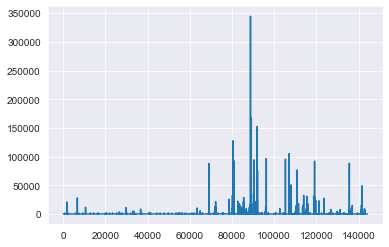

In [98]:
# this cell identifies segments where many duplications occur and NaNs the data from these points:
r_df_framesort = r_df.dropna()
plt.plot(np.diff(r_df_framesort.OE_timestamp.values[:]))

(3600.0, 7200.0)

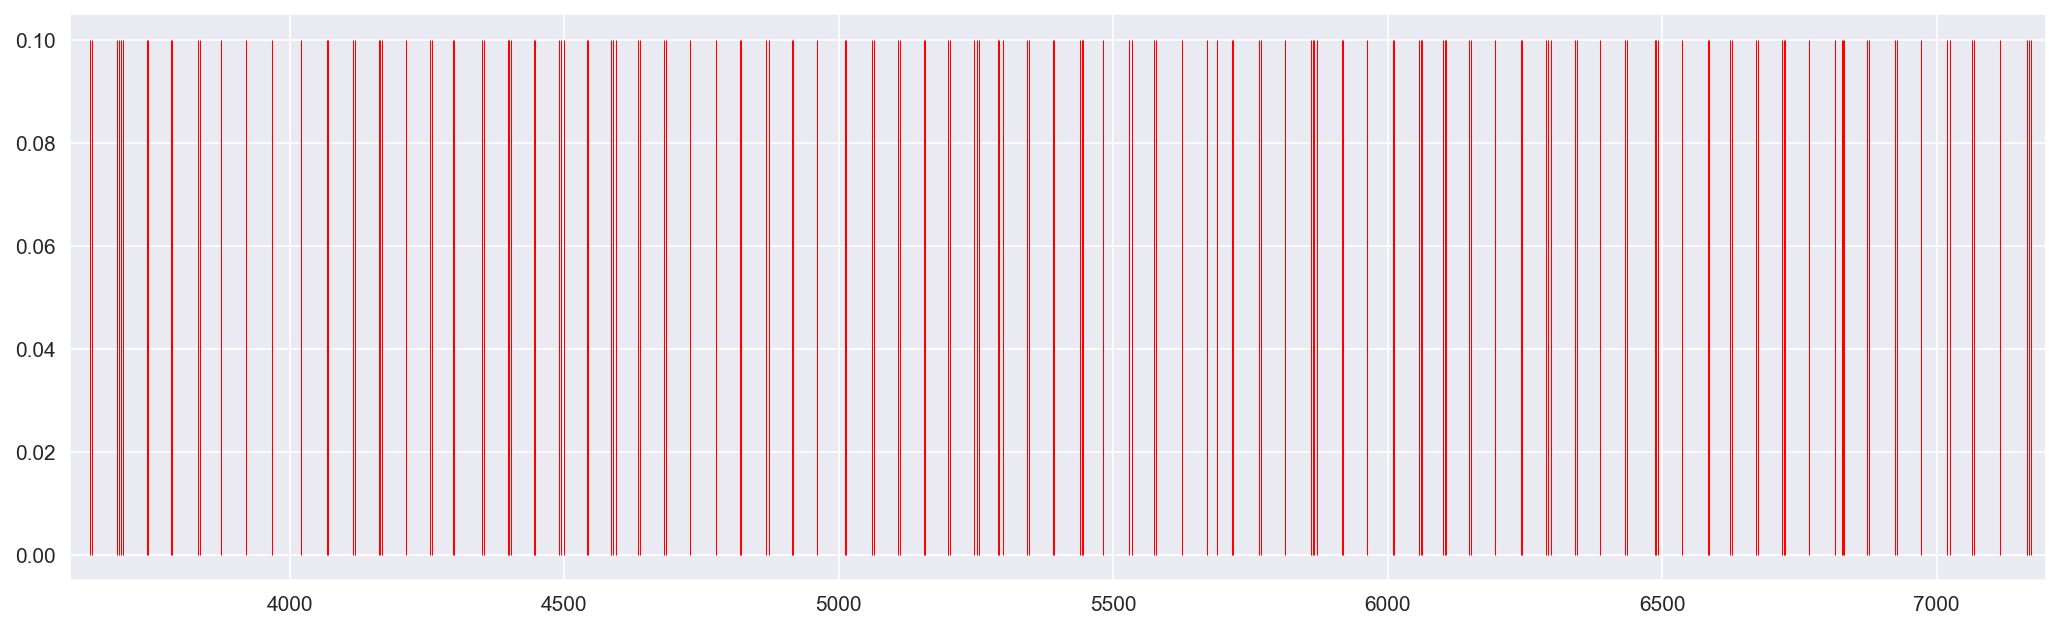

In [79]:
# stupid cell for inspection of duplicate dispersion
fig,axs = plt.subplots(figsize=(17,5),dpi=150)
axs.vlines(result_r['jump_indices'],0,0.1,color='r',linestyles='-',linewidth=0.5)
#axs.vlines(result_r['duplicate_indices'],0,0.1,color='b',linestyles='-', linewidth=0.5)
xlim = np.array([0,3600]) + 3600*1
axs.set_xlim(xlim[0],xlim[1])
#axs.set_xlim(29800,29850)

In [13]:
# This section looks at the RPI report csvs
rpi_df = pd.read_csv([ l for l in pathlib.Path(block.le_videos[0]).parent.iterdir() if 'timestamps.csv' in str(l)][0])

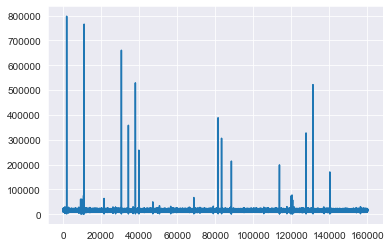

In [19]:
rpi_df['diff'] = rpi_df['# frame timestamp'] - rpi_df[' TTL timestamp']
plt.plot(np.diff(rpi_df[' TTL timestamp'].values))

# The following is the preliminary version of the OE LED blink synchronization
before incorporation into the class

In [19]:
def duplicate_df_row_at_index(df, ind_to_duplicate, correct_ms=True, correct_oe_timestamps=True):
    """
    :param correct_ms: if true, will correct the ms_axis of eye data
    :param df: dataframe 
    :param ind_to_duplicate: which row to duplicate, in iloc logic
    :return: longer df 
    """
    # cut the df
    df_top = df.iloc[:ind_to_duplicate]
    df_bot = df.iloc[ind_to_duplicate:]
    # duplicate the row
    df_top = df_top.append(df_top.iloc[-1])
    df_longer = pd.concat([df_top, df_bot], ignore_index=False)
    if correct_ms:
        df_longer['ms_axis'].iloc[ind_to_duplicate:-1] = df_longer['ms_axis'].iloc[ind_to_duplicate+1:].values
    if correct_oe_timestamps:
        df_longer['OE_timestamp'].iloc[ind_to_duplicate:-1] = df_longer['OE_timestamp'].iloc[ind_to_duplicate+1:].values
    return df_longer.copy()

def remove_df_row_at_index(df, ind_to_remove, correct_ms=True, correct_oe_timestamps=True):
    label_to_remove = df.index[ind_to_remove]
    original_ms_axis = df['ms_axis'].iloc[ind_to_remove:].values
    original_oe_axis = df['OE_timestamp'].iloc[ind_to_remove:].values
    df = df.drop(label_to_remove)
    if correct_ms:
        df['ms_axis'].iloc[ind_to_remove:] = original_ms_axis[:-1]
    if correct_oe_timestamps:
        df['OE_timestamp'].iloc[ind_to_remove:] = original_oe_axis[:-1]
    return df

def correct_relative_eye_drift_based_on_LED_lights_out(block, verification_plots=True):
    r_vals = block.re_frame_val_list[0][1]
    l_vals = block.le_frame_val_list[0][1]
    l_blinks = block.led_blink_frames_l
    r_blinks = block.led_blink_frames_r
    chunks_r = np.insert(np.diff(r_blinks) > 10,0,False)
    r_inds = np.insert(r_blinks[chunks_r],0,r_blinks[0])
    chunks_l = np.insert(np.diff(l_blinks) > 10,0,False)
    l_inds = np.insert(l_blinks[chunks_l],0,l_blinks[0])
    # check for non-matchig lengths
    if len(l_inds) > len(r_inds):
        if max(l_inds) > max(r_inds) + 100: # left with an extra led at the end
            l_inds = l_inds[:len(r_inds)]
        elif min(l_inds) < min(r_inds) - 100: # left with extra led at the beginning
            l_inds = l_inds[1:]
    elif len(r_inds) > len(l_inds):
        if max(r_inds) > max(l_inds) + 100:
            r_inds = r_inds[:len(l_inds)]
        elif min(r_inds) < min(l_inds) - 100:
            r_inds = r_inds[1:]
        
    if verification_plots:
        # verify detection here:
        z_score_data_r = block.rolling_window_z_scores(r_vals, roll_w_size=1500)
        z_score_data_l = block.rolling_window_z_scores(l_vals, roll_w_size=1500)
        
        bokeh_plotter([z_score_data_r, z_score_data_l],
                      label_list=['r_scores', 'l_scores'],
                      x_axis='Frame',
                      y_axis='brightness Z score', 
                      peaks=[r_inds, l_inds], peaks_list=True)
    # I want to understand the drift between the two corrected l_ms vectors now - if a frame appears in two l_ms values, take the larger one (a duplicated frame)
    l_frames = []
    r_frames = []
    l_ms = []
    r_ms = []
    l_blink_inds = []
    r_blink_inds = []
    # collect the l_ms list
    for i, (lb,rb) in enumerate(zip(l_inds,r_inds)):
        l_blink_row = block.left_eye_data.query('eye_frame == @lb')
        r_blink_row = block.right_eye_data.query('eye_frame == @rb')
        #check that both rows exist in the eye dataframes
        if r_blink_row.empty or l_blink_row.empty:
            print('missing frame at',i)
            continue
        l_blink_row = l_blink_row.iloc[-1][['eye_frame', 'ms_axis']]
        l_ms.append(l_blink_row['ms_axis'])
        l_frames.append(l_blink_row['eye_frame'])
        l_blink_inds.append(l_blink_row.name)
        r_blink_row = r_blink_row.iloc[-1][['eye_frame', 'ms_axis']]
        r_ms.append(r_blink_row['ms_axis'])
        r_frames.append(r_blink_row['eye_frame'])
        r_blink_inds.append(r_blink_row.name)
    # This bit creates a map of the neccessary movements to each dataframe in order for the sync to match (for each blink)
    r_arr = np.array([r_frames, r_ms]).T
    l_arr = np.array([l_frames, l_ms]).T
    diff_arr = r_arr[:,1] - l_arr[:,1]
    diff_arr = (diff_arr // 17).astype(int)
    correction_order = []
    l_corrections_inds = []
    l_corrections_size = []
    r_corrections_inds = []
    r_corrections_size = []
    stable_ind_pairs = []
    for i, diff in enumerate(diff_arr):
        if diff > 0: # L lagging
            l_corrections_inds.append(l_blink_inds[i])
            l_corrections_size.append(diff)
            correction_order.append('L')
        elif diff < 0: # R lagging
            r_corrections_inds.append(r_blink_inds[i])
            r_corrections_size.append(np.abs(diff))
            correction_order.append('R')
        else:
            stable_ind_pairs.append([r_blink_inds[i], l_blink_inds[i]])
            correction_order.append('S')
    r_corrections = np.array([r_corrections_inds, r_corrections_size]).T
    l_corrections = np.array([l_corrections_inds, l_corrections_size]).T

    
    # This is the second try:
    l_df = block.left_eye_data.copy()
    r_df = block.right_eye_data.copy()
    print(len(l_df),len(r_df))
    current_l_correction = 0
    current_r_correction = 0
    print(len(r_corrections))
    print(len(l_corrections))
    # Initialize lists to track inserted rows
    inserted_rows_l = []
    removed_rows_l = []
    inserted_rows_r = []
    removed_rows_r = []
    for minute, df_to_correct in enumerate(correction_order):
        print(minute, df_to_correct)
        if df_to_correct == 'L':
            l_corr = l_corrections[current_l_correction]
            inserted_rows_l.append(l_corr)
            print(l_corr)
            for row in range(l_corr[1]):
                l_df = duplicate_df_row_at_index(l_df,l_corr[0], correct_ms=True, correct_oe_timestamps=True)
                inserted_rows_l.append(l_corr[0])
                try:
                    l_df = remove_df_row_at_index(l_df, l_corr[0] + 3534, correct_ms=True, correct_oe_timestamps=True)
                except IndexError or ValueError:
                    l_df = remove_df_row_at_index(l_df, l_df.index[-1])
            current_l_correction += 1
        elif df_to_correct == 'R':
            r_corr = r_corrections[current_r_correction]
            inserted_rows_r.append(r_corr)
            #print(r_corr)
            for row in range(r_corr[1]):
                
                r_df = duplicate_df_row_at_index(r_df,r_corr[0], correct_ms=True)
                try:
                    r_df = remove_df_row_at_index(r_df, r_corr[0] + 3534, correct_ms=True)
                except IndexError or ValueError:
                    r_df = remove_df_row_at_index(r_df, r_df.index[-1], correct_ms=True)
            current_r_correction += 1
        else:
            continue
    
    return l_df.copy(), r_df.copy()

In [72]:
l_df, r_df, inserted_rows_l, inserted_rows_r = correct_relative_eye_drift_based_on_LED_lights_out(block, False)
r_report_arr = np.array([(r[0],r[1]) for r in inserted_rows_r])
l_report_arr = np.array([(r[0].r[1]) for r in inserted_rows_l])
block.left_eye_data = l_df
block.right_eye_data = r_df

missing frame at 26
missing frame at 31
112497 112497
0
0
0 S
1 S
2 S
3 S
4 S
5 S
6 S
7 S
8 S
9 S
10 S
11 S
12 S
13 S
14 S
15 S
16 S
17 S
18 S
19 S
20 S
21 S
22 S
23 S
24 S
25 S
26 S
27 S
28 S
29 S


In [89]:
block.find_led_blink_frames()

100%|██████████| 106/106 [00:00<00:00, 6593.35it/s]

collecting left-eye data
data length is 160087
z_score length is 160087
collecting right eye data
data length is 160087
z_score length is 160087


In [90]:
# get the brightness values of the frames for each eye 
r_vals = block.re_frame_val_list[0][1]
l_vals = block.le_frame_val_list[0][1]

# get the blink frames
l_blinks = block.led_blink_frames_l
r_blinks = block.led_blink_frames_r

# find the beginning sample of the blink frames:
chunks_r = np.insert(np.diff(r_blinks) > 10,0,False)
r_inds = np.insert(r_blinks[chunks_r],0,r_blinks[0])
chunks_l = np.insert(np.diff(l_blinks) > 10,0,False)
l_inds = np.insert(l_blinks[chunks_l],0,l_blinks[0])

# verify:
bokeh_plotter([r_vals, l_vals], ['right','left'], peaks_list=True, peaks=[r_inds,l_inds])



In [20]:
def correct_eye_sync_based_on_LED_OE_events():
    return
# get the brightness values of the frames for each eye 
r_vals = block.re_frame_val_list[0][1]
l_vals = block.le_frame_val_list[0][1]

# get the blink frames
l_blinks = block.led_blink_frames_l
r_blinks = block.led_blink_frames_r

# find the beginning sample of the blink frames:
chunks_r = np.insert(np.diff(r_blinks) > 10,0,False)
r_inds = np.insert(r_blinks[chunks_r],0,r_blinks[0])
chunks_l = np.insert(np.diff(l_blinks) > 10,0,False)
l_inds = np.insert(l_blinks[chunks_l],0,l_blinks[0])



# check for non-matchig lengths
if len(l_inds) > len(r_inds):
    if max(l_inds) > max(r_inds) + 100: # left with an extra led at the end
        print('hi')
        l_inds = l_inds[:len(r_inds)]
    elif min(l_inds) < min(r_inds) - 100: # left with extra led at the beginning
        l_inds = l_inds[1:]
        print('hello')
elif len(r_inds) > len(l_inds):
    if max(r_inds) > max(l_inds) + 100:
        print('hell')
        r_inds = r_inds[:len(l_inds)]
    elif min(r_inds) < min(l_inds) - 100:
        r_inds = r_inds[1:]
        print('helloya')
        
l_df = block.left_eye_data.copy()
r_df = block.right_eye_data.copy()
l_frames = []
r_frames = []
l_ms = []
r_ms = []
l_blink_inds = []
r_blink_inds = []

for i, (lb,rb) in enumerate(zip(l_inds,r_inds)):
    l_blink_row = block.left_eye_data.query('eye_frame == @lb')
    r_blink_row = block.right_eye_data.query('eye_frame == @rb')
    #check that both rows exist in the eye dataframes
    if r_blink_row.empty or l_blink_row.empty:
        print('missing frame at',i)
        continue
    if len(r_blink_row) > 1 or len(l_blink_row) > 1:
        print('double row at', i)
    l_blink_row = l_blink_row.iloc[-1][['eye_frame', 'ms_axis']]
    l_ms.append(l_blink_row['ms_axis'])
    l_frames.append(l_blink_row['eye_frame'])
    l_blink_inds.append(l_blink_row.name)
    r_blink_row = r_blink_row.iloc[-1][['eye_frame', 'ms_axis']]
    r_ms.append(r_blink_row['ms_axis'])
    r_frames.append(r_blink_row['eye_frame'])
    r_blink_inds.append(r_blink_row.name)
r_arr = np.array([r_frames, r_ms]).T
l_arr = np.array([l_frames, l_ms]).T

missing frame at 0
missing frame at 5
double row at 12
missing frame at 14
missing frame at 16
missing frame at 19
missing frame at 20
missing frame at 21
double row at 22
missing frame at 24


In [92]:
bokeh_plotter([r_vals, l_vals], ['right','left'], peaks_list=True, peaks=[r_arr[:,0].astype(int),l_arr[:,0].astype(int)])

In [176]:
np.vstack([r_arr[:,1], l_arr[:,1]]).T 

array([[ 405139.4 ,  405139.4 ],
       [ 466559.05,  466559.05],
       [ 526603.75,  526603.75],
       [ 586624.2 ,  586624.2 ],
       [ 706706.15,  706706.15],
       [ 766735.8 ,  766735.8 ],
       [ 826780.1 ,  826780.1 ],
       [ 886806.5 ,  886806.5 ],
       [ 946835.1 ,  946835.1 ],
       [1006888.9 , 1006888.9 ],
       [1066914.45, 1066914.45],
       [1126951.6 , 1126951.6 ],
       [1247012.95, 1247012.95],
       [1367076.15, 1367076.15],
       [1427138.8 , 1427138.8 ],
       [1667247.8 , 1667247.8 ],
       [1727284.95, 1727284.95],
       [1847362.75, 1847362.75],
       [1907386.95, 1907386.95],
       [1967415.55, 1967415.55],
       [2027447.55, 2027447.55],
       [2087484.55, 2087484.55],
       [2147517.8 , 2147517.8 ],
       [2207558.6 , 2207558.6 ],
       [2267598.6 , 2267598.6 ],
       [2327625.25, 2327625.25],
       [2387654.75, 2387654.75],
       [2447684.6 , 2447684.6 ],
       [2507726.6 , 2507726.6 ],
       [2567747.  , 2567747.  ],
       [26

In [93]:
np.diff(np.vstack([r_arr[:,1], l_arr[:,1]]).T, axis=0) 

array([[ 61419.65,  61419.65],
       [ 60044.7 ,  60044.7 ],
       [ 60020.45,  60020.45],
       [120081.95, 120081.95],
       [ 60029.65,  60029.65],
       [ 60044.3 ,  60044.3 ],
       [ 60026.4 ,  60026.4 ],
       [ 60028.6 ,  60028.6 ],
       [ 60053.8 ,  60053.8 ],
       [ 60025.55,  60025.55],
       [ 60037.15,  60037.15],
       [120061.35, 120061.35],
       [120063.2 , 120063.2 ],
       [ 60062.65,  60062.65],
       [240109.  , 240109.  ],
       [ 60037.15,  60037.15],
       [120077.8 , 120077.8 ],
       [ 60024.2 ,  60024.2 ],
       [ 60028.6 ,  60028.6 ],
       [ 60032.  ,  60032.  ],
       [ 60037.  ,  60037.  ],
       [ 60033.25,  60033.25],
       [ 60040.8 ,  60040.8 ],
       [ 60040.  ,  60040.  ],
       [ 60026.65,  60026.65],
       [ 60029.5 ,  60029.5 ],
       [ 60029.85,  60029.85],
       [ 60042.  ,  60042.  ],
       [ 60020.4 ,  60020.4 ],
       [ 60051.7 ,  60051.7 ],
       [ 60030.95,  60030.95],
       [ 60021.1 ,  60021.1 ],
       [

In [21]:
# This is where the led blink frames are found and a mean correction value is computed
# get ms oe-based blink frames:
oe_led_blinks = block.oe_events[['LED_driver']].query('LED_driver == LED_driver').values
ms_timestamps = oe_led_blinks.T / 20
ms_axis = block.left_eye_data.ms_axis.values
ms_blink_frames = []
# The timestamps now correspond with the real time axis and not the downsampled arena frames time markers - the following code corrects that and finds the closest frames
for t in ms_timestamps[0]:
    ms_blink_frames.append(ms_axis[np.argmin(np.abs(ms_axis - t))])

ms_blink_times = np.array(ms_blink_frames)

def get_timestamp_diff(suspect_times, real_times):
    real_ts = []
    for i,t in enumerate(suspect_times):
        real_t = real_times[np.argmin(np.abs(real_times - t))]
        real_ts.append(real_t)
    return np.array([suspect_times, real_ts, suspect_times - real_ts]).T

l_timestamp_diff = get_timestamp_diff(l_arr[:,1], ms_blink_times)
r_timestamp_diff = get_timestamp_diff(r_arr[:,1], ms_blink_times)

oe_led_blink_correction = np.mean(l_timestamp_diff[1:-1,2]) // 17 # this computes how many 'frame steps' the dataframe needs to take to be synced

# if the correction is positive -> the report is lagging behind real events and needs to move back in time
# if the correction is negative -> the report is produced before actual frames are taken and the reel needs to be pushed forward to synchronize




In [22]:
oe_led_blink_correction

79.0

In [174]:
# oe_lag correction - RUN ONLY ONCE!!!!
df = block.left_eye_data.copy()
df['OE_timestamp'] = df['OE_timestamp'] - oe_led_blink_correction*17*20
df['ms_axis'] = df['ms_axis'] - oe_led_blink_correction*17 
block.left_eye_data = df # this df should be corrected to OE events!

df = block.right_eye_data.copy()
df['OE_timestamp'] = df['OE_timestamp'] - oe_led_blink_correction*17*20
df['ms_axis'] = df['ms_axis'] - oe_led_blink_correction*17 
block.right_eye_data = df # this df should be corrected to OE events!


In [112]:
# This is a verification of the blink-step problem (lag between LED_driver_TTLs and led blinks in eye videos)

le_TTLs = block.oe_events.L_eye_TTL.dropna()
led_driver_TTLs = block.oe_events.LED_driver.dropna()
le_TTLs.values[np.argmin(np.abs(le_TTLs.values - led_driver_TTLs.values[3]))]
def play_video(video_path, start_frame=0):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Unable to open video file.")
        return

    # Set the start frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    
    frames_played = start_frame

    while True:
        ret, frame = cap.read()
        if not ret:
            print("End of video.")
            break

        # Draw frame count on the frame
        cv2.putText(frame, f"Frames played: {frames_played - start_frame}", (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        cv2.imshow('Video', frame)
        
        frames_played += 1

        key = cv2.waitKey(0)
        if key == ord('q'):
            break
        elif key == ord('n'):
            continue

    cap.release()
    cv2.destroyAllWindows()


video_path = block.le_videos[0]
play_video(video_path=video_path, start_frame=11669+3680)


In [104]:
dlc_csv_path =r'Z:\Nimrod\3D_calibration\Test_Dataset\Eye_angle_test_random_movementsDLC_resnet_50_Eye_Tracking_piplineMar1shuffle1_950000.csv'
le_csv = pd.read_csv(dlc_csv_path, header=1)
ellipse_df = block.eye_tracking_analysis(le_csv,0.6)
ellipse_df

100%|██████████| 499/499 [00:00<00:00, 1782.21it/s]


 ellipses calculation complete


,center_x,center_y,width,height,phi,ellipse_size
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
494,300.791002,221.603339,70.292923,67.290508,0.023982,14859.879209
495,306.324043,224.135213,72.716317,67.412158,0.285855,15399.973656
496,312.557446,229.092076,75.100778,67.140380,0.140160,15840.836355
497,316.224135,233.315824,74.134170,70.348368,0.193882,16384.090047


In [109]:
# this shows the video with the ellipse:
export_path = r'Z:\Nimrod\3D_calibration\Test_Dataset\elliipse_fit_test.mp4' 
ellipse_dataframe = ellipse_df 
video_path = r'Z:\Nimrod\3D_calibration\Test_Dataset\Eye_angle_test_random_movementsDLC_resnet_50_Eye_Tracking_piplineMar1shuffle1_950000_labeled.mp4'
transformation_matrix=None
xflip=True
# Open the video file
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    raise Exception("Error: Unable to open video file.")
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(export_path, fourcc, 30, (int(cap.get(3)), int(cap.get(4))))
# Loop through each frame
while True:
    # Read a frame from the video
    ret, frame = cap.read()

    if not ret:
        # Break the loop if the video is finished
        break
    
    # Optionally flip the frame along the x-axis
    if xflip:
        frame = cv2.flip(frame, 1)

    # Apply transformation matrix if provided
    if transformation_matrix is not None:
        frame = cv2.warpAffine(frame, transformation_matrix, (frame.shape[1], frame.shape[0]))

    # Get the corresponding ellipse data for the current frame
    current_frame_num = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 1
    try:
        current_frame_data = ellipse_dataframe.iloc[ellipse_dataframe.query('index == @current_frame_num').index[0]]
    except IndexError:
        continue

    # Extract ellipse parameters
    if transformation_matrix is not None:
        try:
            center_x = int(current_frame_data['center_x'])
            center_y = int(current_frame_data['center_y'])
            width = int(current_frame_data['width'])
            height = int(current_frame_data['height'])
            phi = float(current_frame_data['phi'])
            
            # Draw the ellipse on the frame
            cv2.ellipse(frame, (center_x, center_y), (width, height), phi, 0, 360, (0, 255, 0), 2)
            
            # Add text to the frame
            text = f'ellipse angle: {phi}'
            cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    
            
            # Display the frame
            cv2.imshow('Video with Ellipses', frame)
        
            # Check for the 'q' key to quit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        except ValueError:
            continue
    else:
        try:
            center_x = int(current_frame_data['center_x'])
            center_y = int(current_frame_data['center_y'])
            width = int(current_frame_data['width'])
            height = int(current_frame_data['height'])
            phi = float(current_frame_data['phi'])
    
            # Draw the ellipse on the frame
            cv2.ellipse(frame, (center_x, center_y), (width, height), phi, 0, 360, (0, 255, 0), 2)
            
            # Add text to the frame
            text = f'ellipse angle: {phi}'
            cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
            
            # Display the frame
            cv2.imshow('Video with Ellipses', frame)
        
        
            out.write(frame)
            # Check for the 'q' key to quit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        except ValueError:
            continue

# Release video capture object and close the window
cap.release()
out.release()
cv2.destroyAllWindows()